In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/PotatoData',
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for images_batch, label_batch in dataset.take(1):
    # print(images_batch[0].numpy())
    print(images_batch[0].shape)
    # print(images_batch.shape)
    # print(label_batch.numpy())

(256, 256, 3)


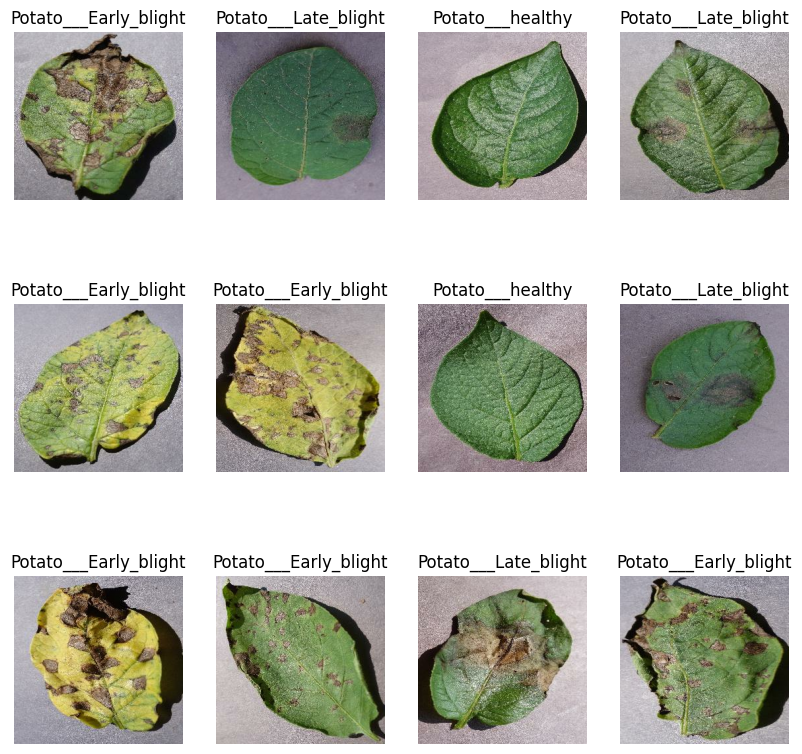

In [7]:
plt.figure(figsize=(10,10))
for images_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(images_batch[i].numpy().astype(np.uint8))
    plt.title(class_name[label_batch[i]])
    plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_df = dataset.take(54)
len(train_df)

54

In [10]:
test_df = dataset.skip(54)
len(test_df)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_df = test_df.take(6)
len(val_df)

6

In [13]:
test_df = test_df.skip(6)
len(test_df)

8

In [14]:
def get_dataset_partitions_tf(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    df_size = len(df)

    if shuffle:
        df = df.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * df_size)
    val_size = int(val_split * df_size)

    train_df = df.take(train_size)
    val_df = df.skip(train_size).take(val_size)
    test_ddf = df.skip(train_size).skip(val_size)

    return train_df, val_df, test_df

In [15]:
train_df, val_df, test_df = get_dataset_partitions_tf(dataset)

In [16]:
len(train_df), len(val_df), len(test_df)

(54, 6, 8)

In [17]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=1, verbose=1, mode='auto')

call = [early]

In [24]:
history = model.fit(
    train_df,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_df,
    callbacks=call
)

Epoch 1/50
54/54 [==============================] - 26s 156ms/step - loss: 0.8925 - accuracy: 0.5260 - val_loss: 0.8075 - val_accuracy: 0.5625
Epoch 2/50
54/54 [==============================] - 3s 59ms/step - loss: 0.5907 - accuracy: 0.7355 - val_loss: 0.4144 - val_accuracy: 0.8490
Epoch 3/50
54/54 [==============================] - 3s 61ms/step - loss: 0.3468 - accuracy: 0.8519 - val_loss: 0.3231 - val_accuracy: 0.8490
Epoch 3: early stopping


In [32]:
score = model.evaluate(test_df)
score

8/8 [==============================] - 0s 25ms/step - loss: 0.2756 - accuracy: 0.9052


[0.27558135986328125, 0.9051724076271057]

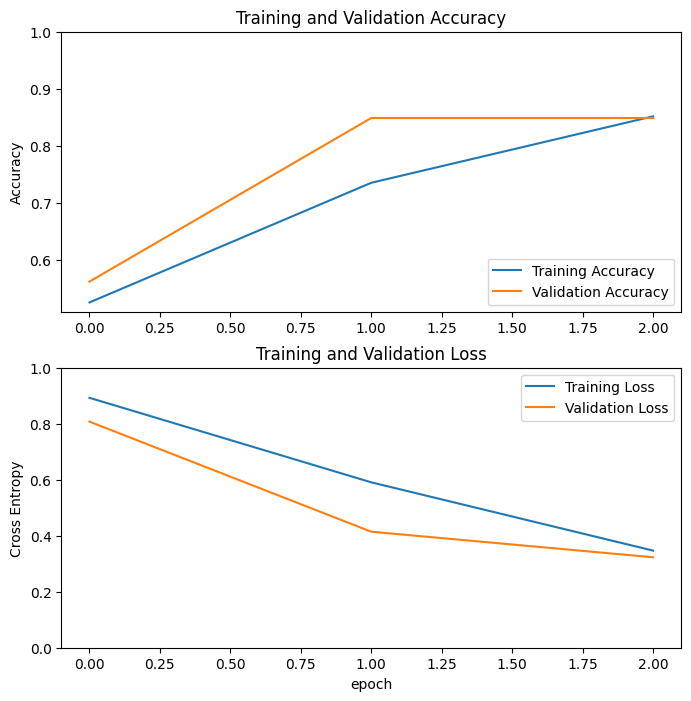

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

First image to predict
actual label:  Potato___Late_blight
1/1 [==============================] - 0s 63ms/step
Predicted label:  Potato___Late_blight


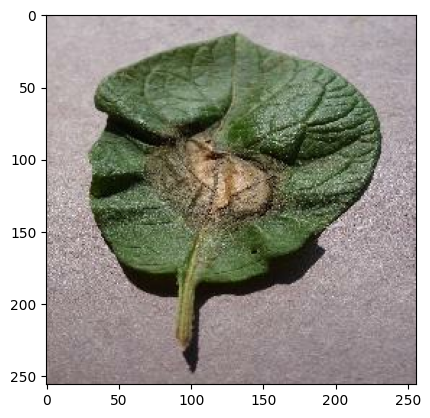

In [36]:
for images_batch, labels_batch in test_df.take(1):
  first_image = images_batch[0].numpy().astype(np.uint8)
  first_label = labels_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("actual label: ", class_name[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted label: ", class_name[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


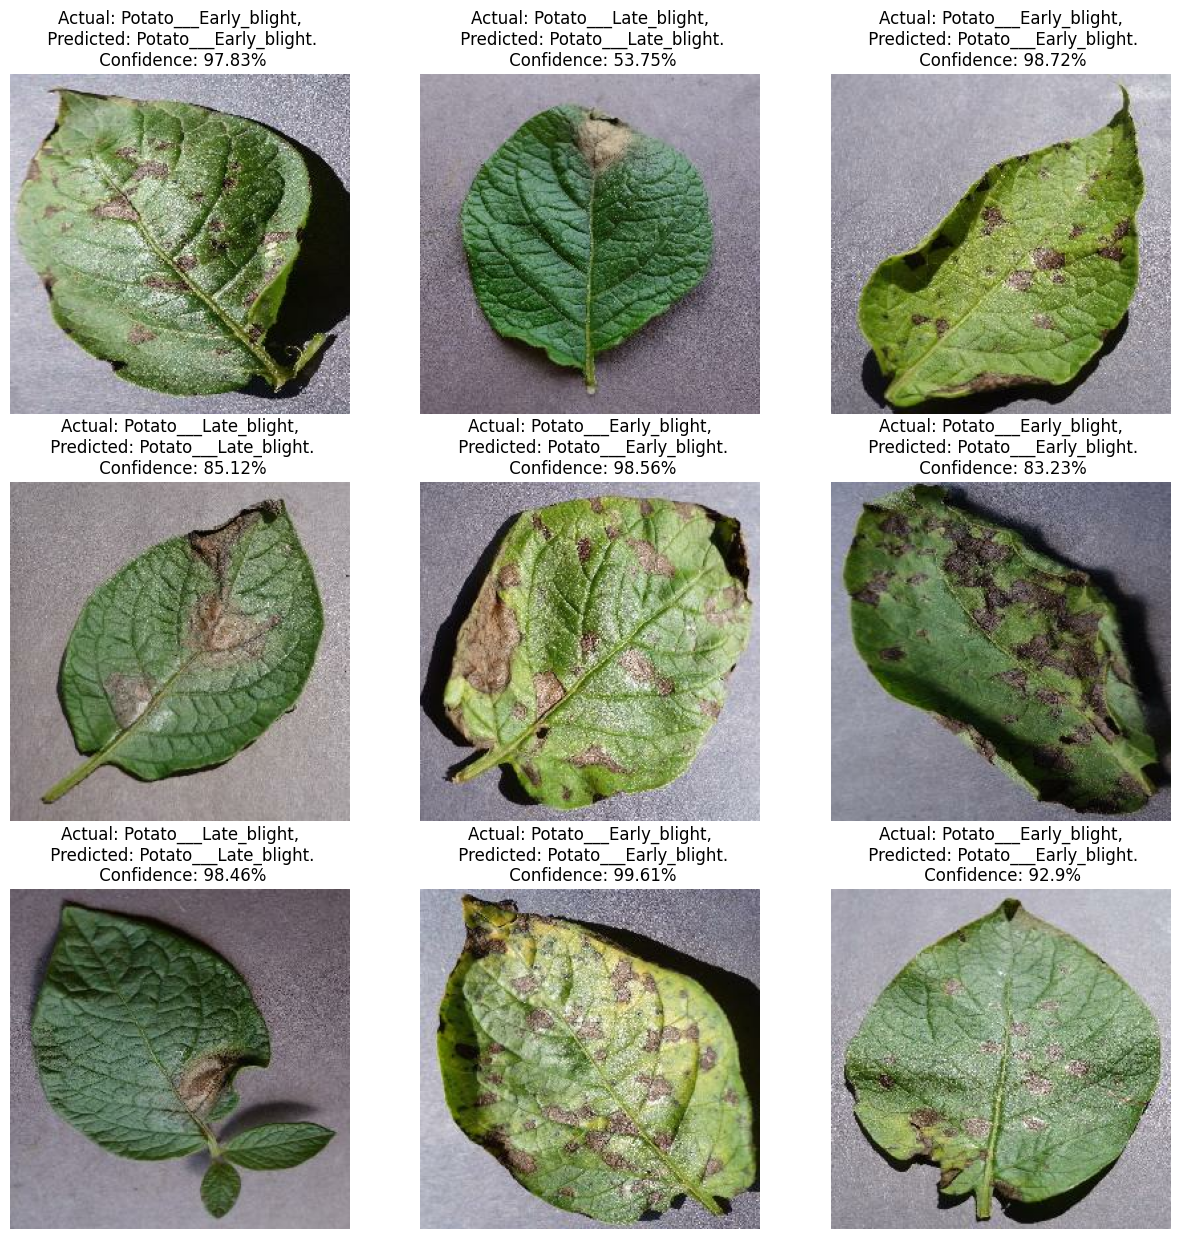

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [39]:
import os
model_version = 1
model.save(f"/content/drive/MyDrive/PotatoData/model/{model_version}")

In [40]:
model.save("models_1.h5")